Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when the cells are run one at a time sequentially, not all at once.

## Resource Conservation and Recovery Act Violations by Congressional District

This notebook examines ECHO data using ECHO_EXPORTER, RCRA_FACILITIES,
and RCRA_VIOLATIONS.

From ECHO_EXPORTER:
<ul>
    <li>RCRA_IDS - to match facilities/violations in RCRA_FACILITIES and RCRA_VIOLATIONS</li>
    <li>FAC_DERIVED_CD113 - 113th congressional district</li>
    <li>FAC_LAT and FAC_LONG - latitude and longitude</li>
    <li>RCRA_PERMIT_TYPES</li>
</ul>

RCRA Permit Types include:
<ul>
    <li>TSDF = Treatment, Storage and Disposal facility</li>
    <li>LQG = Large Quantity Generator</li>
    <li>SQG = Small Quantity Generator</li>
    <li>CESQG = Conditionally-Exempt Small Quantity Generator</li>
</ul>


A state and congressional district must be chosen using the dropdown
widgets that are provided.

In [1]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


Run this next cell, select a state, and then run the following cell.

In [2]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

Run this next cell after choosing a state from the dropdown list.

In [3]:
my_state = dropdown_state.value

sql = "select FAC_NAME, FAC_LAT, FAC_LONG, RCRA_IDS, " + \
    "RCRA_PERMIT_TYPES, FAC_DERIVED_CD113 from ECHO_EXPORTER where RCRA_FLAG = 'Y'" + \
    "and FAC_STATE = '" + my_state + "'" 
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)

select FAC_NAME, FAC_LAT, FAC_LONG, RCRA_IDS, RCRA_PERMIT_TYPES, FAC_DERIVED_CD113 from ECHO_EXPORTER where RCRA_FLAG = 'Y'and FAC_STATE = 'NY'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20FAC_NAME%2C%20FAC_LAT%2C%20FAC_LONG%2C%20RCRA_IDS%2C%20RCRA_PERMIT_TYPES%2C%20FAC_DERIVED_CD113%20from%20ECHO_EXPORTER%20where%20RCRA_FLAG%20%3D%20%27Y%27and%20FAC_STATE%20%3D%20%27NY%27


In [4]:
echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)

num_facilities = echo_data.shape[0]
print("There are %s RCRA facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.
Here is a map of congressional districts: https://www.govtrack.us/congress/members/map

In [6]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=1,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…



Run this next cell after choosing a congressional district from the dropdown list.

In [14]:
my_cd = w2.value
my_cd_facs = echo_data[echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s RCRA facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 2788 RCRA facilities in NY district 21 tracked in the ECHO database.


Next look up the violation history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [15]:
sql = "select ID_NUMBER, DATE_VIOLATION_DETERMINED from `RCRA_VIOLATIONS` " + \
        "where ID_NUMBER like '" + my_state + "%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
# print(data_location)
rcra_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
rcra_data.set_index( "ID_NUMBER", inplace=True)
rcra_data

,DATE_VIOLATION_DETERMINED
ID_NUMBER,
NYD064743263,03/13/2002
NYD987024213,09/20/2007
NYD006866008,03/31/2008
NYD002044196,04/20/2005
NYD055057111,10/25/2007
...,...
NYD002080034,11/05/2008
NYD020672820,08/21/2015
NYD980789218,06/25/2012


In [16]:
# The RCRA_IDS can contain multiple ids for a facility. 
# The string must be parsed to get each individual id to look up in RCRA_VIOLATION_HISTORY.

cd_rcra = pd.DataFrame()
no_data_ids = []
# Look through all facilities in my CD.
for fac in my_cd_facs.itertuples():
    # print( type( fac ))
    # breakpoint()
    ids = fac.RCRA_IDS
    # Look at each RCRA_ID belonging to the facility
    for rcra_id in ids.split():
        try:
            # Find the rcra_id in the RCRA_VIOLATION_HISTORY, if any exist there.
            # It can match a ID_NUMBER, which is the index of rcra_data.
            rcra_fac = rcra_data.loc[ rcra_id ].copy()
            # Add the facility's index number to rcra_fac, to refer to it.
            n = rcra_fac.shape[0]
            fac_list = [fac.Index] * n
            rcra_fac['facility'] = fac_list
            # Make a frame that contains the violations.  Add it to my_cd_icis.
            frames = [cd_rcra, rcra_fac]
            cd_rcra = pd.concat( frames, ignore_index=False )
        except KeyError:
            # The air_id wasn't found in RCRA_VIOLATION_HISTORY.
            no_data_ids.append( rcra_id )

cd_rcra

# my_cd_icis.to_csv( r'my_cd_icis.csv', index=True, header=True )
# with open( "no_data_ids.txt", "w" ) as output:
#     output.write( str( no_data_ids ))

,0,DATE_VIOLATION_DETERMINED,facility
DATE_VIOLATION_DETERMINED,07/28/2010,NaN,NaN
facility,[481],NaN,NaN
NYD990762148,NaN,11/05/2008,1056.0
NYD990762148,NaN,01/14/2014,1056.0
NYD990762148,NaN,11/05/2008,1056.0
...,...,...,...
NYR000110700,NaN,03/14/2014,113771.0
DATE_VIOLATION_DETERMINED,08/01/2001,NaN,NaN
facility,[113889],NaN,NaN
NYD066815572,NaN,10/11/1994,114512.0


Map the facilities that have had these serious CAA violations.

In [17]:
fac_idx_list = cd_rcra['facility'].dropna()
fac_cd_rcra = my_cd_facs.loc[fac_idx_list]
fac_cd_rcra

,FAC_NAME,FAC_LAT,FAC_LONG,RCRA_IDS,RCRA_PERMIT_TYPES,FAC_DERIVED_CD113
1056.0,QUBICA AMF BOWLING PRODUCTS,43.779844,-75.483668,NYD987002573 NYD990762148,SQG,21.0
1056.0,QUBICA AMF BOWLING PRODUCTS,43.779844,-75.483668,NYD987002573 NYD990762148,SQG,21.0
1056.0,QUBICA AMF BOWLING PRODUCTS,43.779844,-75.483668,NYD987002573 NYD990762148,SQG,21.0
1056.0,QUBICA AMF BOWLING PRODUCTS,43.779844,-75.483668,NYD987002573 NYD990762148,SQG,21.0
1056.0,QUBICA AMF BOWLING PRODUCTS,43.779844,-75.483668,NYD987002573 NYD990762148,SQG,21.0
...,...,...,...,...,...,...
113771.0,UMICORE TECHNICAL MATERIALS NORTH AMERICA INC,43.296950,-73.643150,NYR000110700,LQG,21.0
113771.0,UMICORE TECHNICAL MATERIALS NORTH AMERICA INC,43.296950,-73.643150,NYR000110700,LQG,21.0
113771.0,UMICORE TECHNICAL MATERIALS NORTH AMERICA INC,43.296950,-73.643150,NYR000110700,LQG,21.0
114512.0,BDP INDUSTRIES INC,43.092490,-73.543070,NYD066815572,VSQG,21.0


In [18]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_cd = mapper(fac_cd_rcra)
map_of_facilities_in_cd

Present another dropdown with the list of names of the facilities.  Choosing a facility will display
the violations.

In [19]:
cd_array = fac_cd_rcra["FAC_NAME"].unique()
cd_array.sort()

w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Dropdown(description='Facility Name:', options=('4X HEAVEN', 'ACE HARDWARE CORP', 'ADIRONDACK FURNITURE STRIPP…

Run this next cell after choosing a facility.

RCRA Permit Types:
<ul>
    <li>TSDF = Treatment, Storage and Disposal facility</li>
    <li>LQG = Large Quantity Generator</li>
    <li>SQG = Small Quantity Generator</li>
    <li>CESQG = Conditionally-Exempt Small Quantity Generator</li>
</ul>

In [20]:
my_fac = fac_cd_rcra[fac_cd_rcra["FAC_NAME"] == w3.value]
violations = cd_rcra[cd_rcra['facility'] == my_fac.iloc[[0]].index[0]]
print( my_fac.iloc[0] )
violations


FAC_NAME             BASF CORPORATION
FAC_LAT                        43.386
FAC_LONG                     -73.6207
RCRA_IDS                 NYD000818419
RCRA_PERMIT_TYPES           LQG, TSDF
FAC_DERIVED_CD113                  21
Name: 65958.0, dtype: object


,0,DATE_VIOLATION_DETERMINED,facility
NYD000818419,NaN,04/28/1986,65958.0
NYD000818419,NaN,08/01/1985,65958.0
NYD000818419,NaN,09/04/1985,65958.0
NYD000818419,NaN,01/09/2013,65958.0
NYD000818419,NaN,03/29/1985,65958.0
NYD000818419,NaN,12/30/1993,65958.0
NYD000818419,NaN,03/21/2008,65958.0
NYD000818419,NaN,05/07/1985,65958.0
NYD000818419,NaN,01/09/2013,65958.0
NYD000818419,NaN,06/06/2011,65958.0


In [21]:
# This cell creates a function that will be used by both the CD and the state
# to plot the number of cases by year.
import datetime

def show_plot( df, date_field, year_field, place, date_format, chart_title ):
    format_str = date_format # The format
    nan_count = 0
    year_col = []
    for day in df[date_field]:
        try:
            # breakpoint()
            viol_year = datetime.datetime.strptime(day, format_str).year
            year_col.append( viol_year )
        except:
            nan_count += 1
            year_col.append(  np.NaN )
    df[year_field] = year_col
    
    year_groups = df.groupby( year_field )[[ year_field ]]
    counted_years = year_groups.count()

    # Print how many values are present 
    print(counted_years)
    chart_title +=  " in " + place + " by year"

    ax = counted_years[[year_field]].plot(kind='bar', title = chart_title, figsize=(15, 10), legend=False, fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

## Plot the number of violations by year for the congressional district.

                YEAR_VIOLATION
YEAR_VIOLATION                
1981.0                       1
1983.0                       5
1984.0                      14
1985.0                      29
1986.0                      29
1987.0                      32
1988.0                      22
1989.0                      12
1990.0                      12
1991.0                      15
1992.0                      18
1993.0                      17
1994.0                      10
1995.0                       3
1996.0                      20
1997.0                      23
1998.0                      15
1999.0                      15
2000.0                       7
2001.0                      11
2002.0                      17
2003.0                       6
2004.0                      22
2005.0                       7
2006.0                      17
2007.0                      33
2008.0                      24
2009.0                      14
2010.0                      24
2011.0                      10
2012.0  

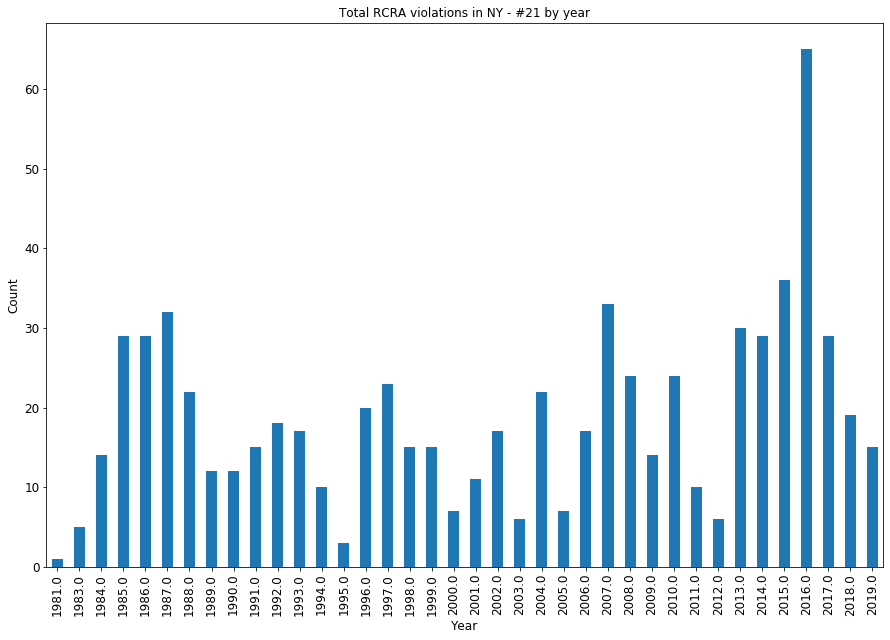

In [22]:
chart_title = "Total RCRA violations"

show_plot( cd_rcra, 'DATE_VIOLATION_DETERMINED', 'YEAR_VIOLATION', \
          my_state + ' - #' + str( my_cd ), '%m/%d/%Y', chart_title )

## Plot the number of violations by year, using the entire state.
Since the number of violations in a single CD may be small, it can be more
interesting to look at the entire state.

                YEAR_VIOLATION
YEAR_VIOLATION                
1980                         1
1981                        11
1982                        25
1983                       191
1984                       385
1985                       571
1986                       728
1987                       730
1988                       676
1989                       594
1990                       656
1991                       509
1992                       489
1993                       795
1994                       683
1995                       449
1996                       560
1997                       592
1998                       509
1999                       663
2000                       551
2001                       460
2002                       452
2003                       478
2004                       479
2005                       549
2006                       902
2007                      1400
2008                      1539
2009                      1367
2010    

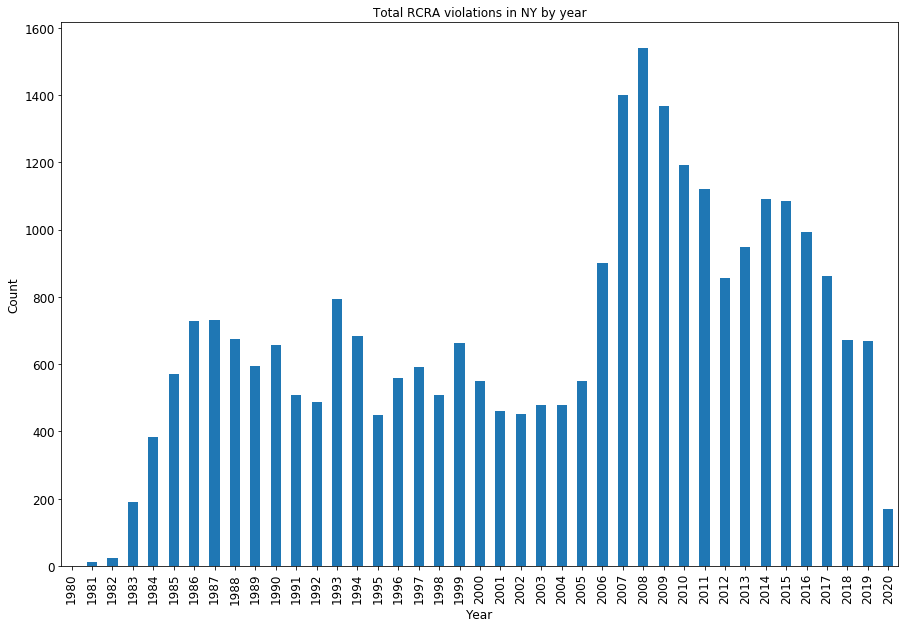

In [23]:
chart_title = "Total RCRA violations"

show_plot( rcra_data, 'DATE_VIOLATION_DETERMINED', 'YEAR_VIOLATION', \
          my_state, '%m/%d/%Y', chart_title )